# Testing with CATBoost

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_theme()
from catboost import CatBoostClassifier


import sys; sys.path.append("../../")
from modules.utils import load_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/stefano/botu/aichallenge-2022/notebooks/fede/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [3]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]


../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [4]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

## Imbalanced learning

We should attempt something for the data imbalance: better check this out

NOTE: this simple trick seems to be working!

### Weights

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(5), y=train_y)

### Smote

In [6]:
MODEL_NAME = 'CATBoost - SMOTE'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

# Optuna optimization

https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_simple.py

In [33]:
import optuna
from sklearn.metrics import f1_score, accuracy_score

# Setup metrics and data
metric = f1_score
metric_kwargs = {'average':'macro'}
# data = [train_X, valid_X, train_y, valid_y] # normal data
data = [X_oversample, valid_X, y_oversample, valid_y] # oversampled data

def objective(trial):
    train_x, valid_x, train_y, valid_y = data

    param = {
        # "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'objective': 'MultiClass',
        'eval_metric': 'TotalF1',
        'custom_metric': 'TotalF1',
        # "depth": trial.suggest_int("depth", 8, 10), #1,12
        "depth": 10,
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "l2_leaf_reg": trial.suggest_discrete_uniform("l2_leaf_reg", 0.002, 0.2, 0.002),
        "used_ram_limit": "64gb",
        "task_type": "GPU",
        "devices": '2:3'
   }

    # if param["bootstrap_type"] == "Bayesian":
    #     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    # elif param["bootstrap_type"] == "Bernoulli":
    #     param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    target_metric = metric(valid_y, pred_labels, **metric_kwargs)
    return target_metric


In [34]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600, show_progress_bar=True)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-10 01:24:04,202] A new study created in memory with name: no-name-5b597463-244a-41c7-968a-9b74d3d25f83
/home/stefano/botu/aichallenge-2022/notebooks/fede/env/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  0%|          | 0/100 [00:28<?, ?it/s]


KeyboardInterrupt: 

# Train Models

<!-- Tricks: we can use custom parameters to maximize the F1 score -->

Learning rate set to 0.080175
0:	learn: 0.4740430	test: 0.6204980	best: 0.6204980 (0)	total: 55ms	remaining: 4m 34s
200:	learn: 0.9124161	test: 0.8720864	best: 0.8723811 (199)	total: 5.35s	remaining: 2m 7s
400:	learn: 0.9627633	test: 0.9031265	best: 0.9034585 (398)	total: 10.3s	remaining: 1m 57s
600:	learn: 0.9787672	test: 0.9177693	best: 0.9180500 (599)	total: 15s	remaining: 1m 50s
800:	learn: 0.9866960	test: 0.9244984	best: 0.9247931 (797)	total: 19.7s	remaining: 1m 43s
1000:	learn: 0.9910344	test: 0.9285389	best: 0.9288373 (998)	total: 24.4s	remaining: 1m 37s
1200:	learn: 0.9943038	test: 0.9309734	best: 0.9315679 (1197)	total: 29.2s	remaining: 1m 32s
1400:	learn: 0.9962991	test: 0.9345101	best: 0.9349454 (1394)	total: 33.9s	remaining: 1m 27s
1600:	learn: 0.9973663	test: 0.9352760	best: 0.9360485 (1579)	total: 38.6s	remaining: 1m 21s
1800:	learn: 0.9982393	test: 0.9375957	best: 0.9382156 (1790)	total: 43.3s	remaining: 1m 16s
2000:	learn: 0.9987938	test: 0.9388415	best: 0.9394493 (191

,precision,recall,f1-score,support
0,0.937102,0.945118,0.941093,1403
1,0.930762,0.927094,0.928924,1015
2,0.992733,0.970492,0.981487,3660
3,0.726287,0.861736,0.788235,311
4,0.783862,0.821752,0.802360,331
accuracy,0.946280,0.946280,0.946280,0
macro avg,0.874149,0.905238,0.888420,6720
weighted avg,0.949139,0.946280,0.947347,6720


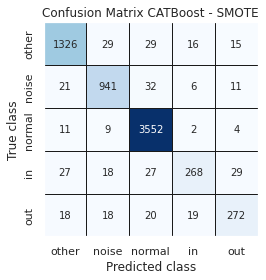

In [58]:
clf = CatBoostClassifier(
    iterations=5000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    depth=9,
    devices='2:3',
    # learning_rate=0.3
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

In [61]:
MODEL_NAME = 'CATBoost - SMOTE - ALL DATA'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

total_train_X, total_train_y =  pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_y, valid_y], ignore_index=True)
X_oversample, y_oversample = smote.fit_resample(total_train_X, total_train_y)

clf = CatBoostClassifier(
    iterations=10000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # depth=10,
    depth=15,
    devices='2:3',
    # learning_rate=0.3
    # class_weights=class_weights
)

clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.060563
0:	learn: 0.6121686	test: 0.7070408	best: 0.7070408 (0)	total: 1.03s	remaining: 2h 51m 41s


KeyboardInterrupt: 

## Actual test for submission

In [60]:
# Setup
model = clf
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
RESULTS_PATH = '.'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
test_X = test_df.loc[:,test_df.columns!='id']
test_ids = test_df['id']


# Make predictions
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])

y_pred = model.predict(test_X)
y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# sort predictions
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()
resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
result.to_csv(resultpath, index=False)